In [1]:
from IPython.display import Image

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm
import os

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

In [4]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
from pylab import *

# Загрузка данных

In [7]:
images = glob.glob("dataset/train/train/*.jpg")
imageCount = 0
for image in images:
    imageCount +=1
    #with open(image, 'rb') as file:
        #img = Image.open(file)
        #imageSet.append(Image.open(file))
        #img.show()
print(imageCount)

10000


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
PATH = 'C:/Users/Andrej/1_GAN/dataset'


In [12]:
data_dir = PATH + '/train' # load from Kaggle

In [13]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                #transforms.CenterCrop(28),
                                transforms.ToTensor()
                               ])# TODO: compose transforms here
dataset_train = datasets.ImageFolder(data_dir, transform=transform) # TODO: create the ImageFolder
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader

In [10]:
dataset_train

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: C:/Users/Andrej/1_GAN/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Просмотр изображения

In [104]:
#images, labels = next(iter(dataloader))

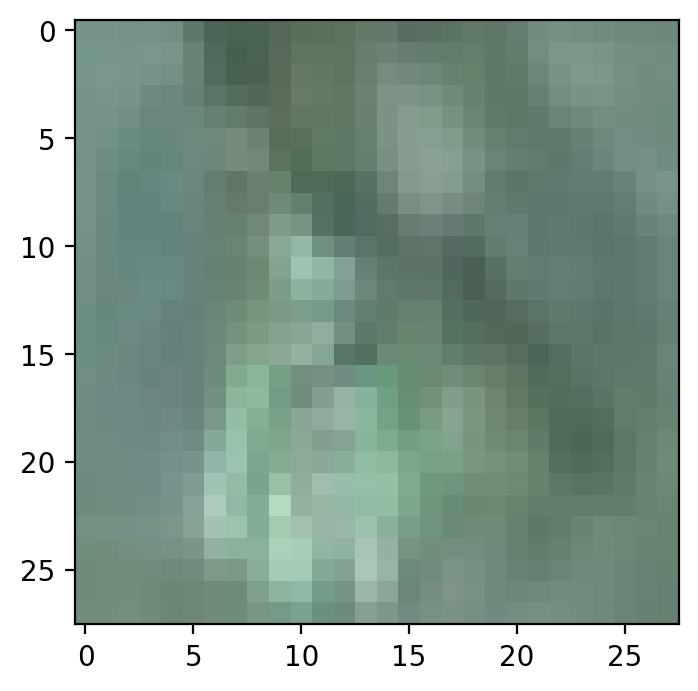

In [105]:
#plt.imshow(torch.einsum('cwh->whc', images[0]))

# Модель

In [82]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 1024)
        self.linear2 = nn.Linear(1024, 2352)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 28, 28))

In [108]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(2352, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [85]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Обучение

In [86]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    lossTrack = list()
    epochList = list()
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + 0.02*autoencoder.encoder.kl
            #print("((x - x_hat)**2).sum(): ",((x - x_hat)**2).sum().to('cpu').detach().numpy())
            #print("kl: ",autoencoder.encoder.kl.to('cpu').detach().numpy())
            loss.backward()
            opt.step()
        lossTrack.append(((x - x_hat)**2).sum().to('cpu').detach().numpy())
        epochList.append(epoch)
    
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.plot(epochList, lossTrack)
    plt.show()
    
    return autoencoder

In [87]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Просмотр MSE по эпохам

100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


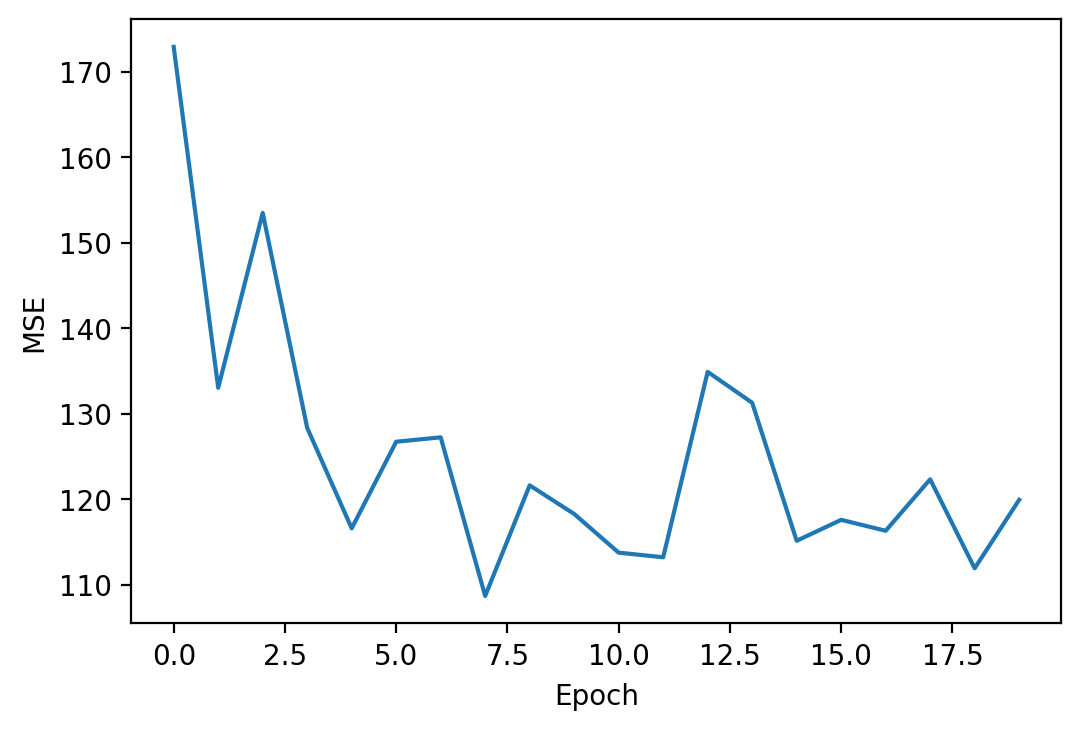

In [110]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, dataloader_train)

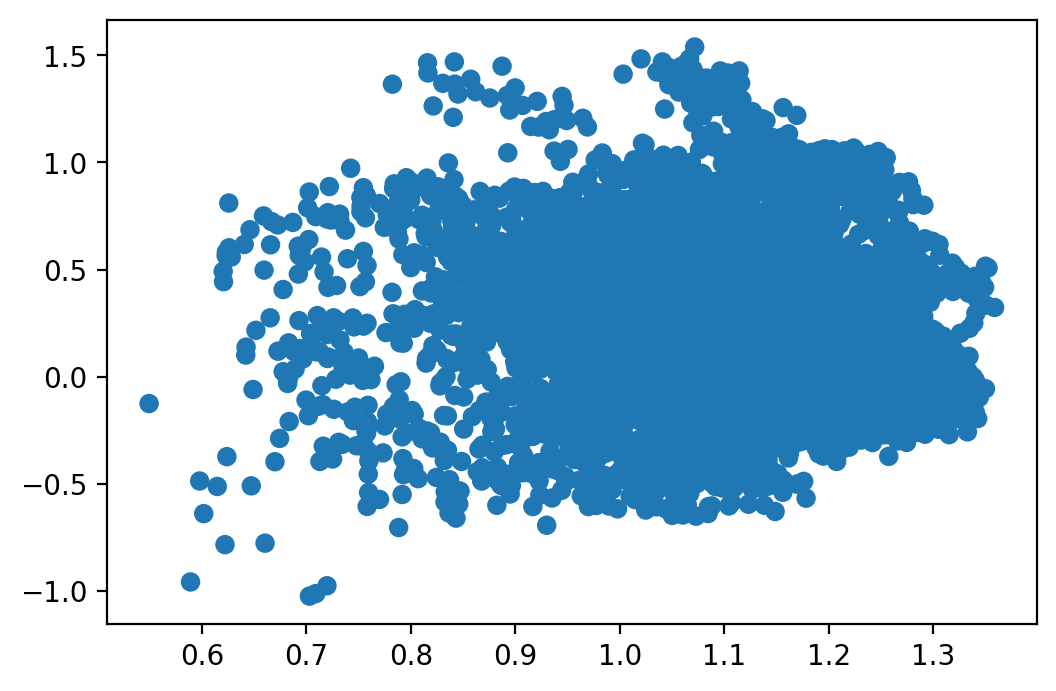

In [112]:
# Внутренее расположение данных в скрытом пространстве
plot_latent(vae, dataloader_train)

# Вычисление порога

In [151]:
def threshold_determine(autoencoder, data):
    lossTrack = list()
    
    count = 0
    for x, y in data:
        count+=1
        x = x.to(device) # GPU
        x_hat = autoencoder(x)

        lossTrack.append(((x - x_hat)**2).sum().to('cpu').detach().numpy())

    axesX = range(len(lossTrack))
    print("Count: ",count)
    print("Loss mean: ",sum(lossTrack)/len(lossTrack))
    plt.xlabel("Data")
    plt.ylabel("MSE")
    plt.plot(axesX, lossTrack)
    plt.show()

In [152]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                #transforms.CenterCrop(28),
                                transforms.ToTensor()
                               ])
dataset_threshold = datasets.ImageFolder(data_dir, transform=transform) 
dataloader_threshold = torch.utils.data.DataLoader(dataset_threshold, shuffle=True) 

Count:  10000
Loss mean:  7.2921953125


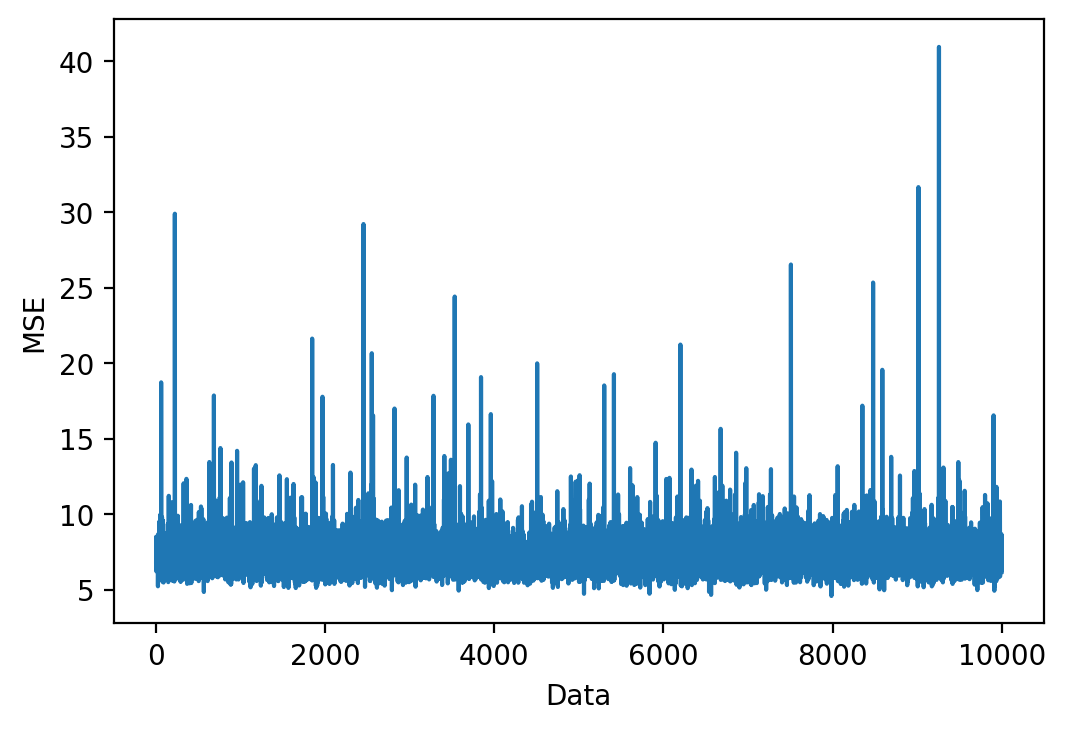

In [153]:
threshold_determine(vae, dataloader_threshold)

Загрузка данных с проливом

In [116]:
data_dir_proliv = PATH + '/proliv' 

In [117]:

dataset_proliv = datasets.ImageFolder(data_dir_proliv, transform=transform) 
dataloader_proliv = torch.utils.data.DataLoader(dataset_proliv) 

Count:  154
Loss mean:  16.411589387175326


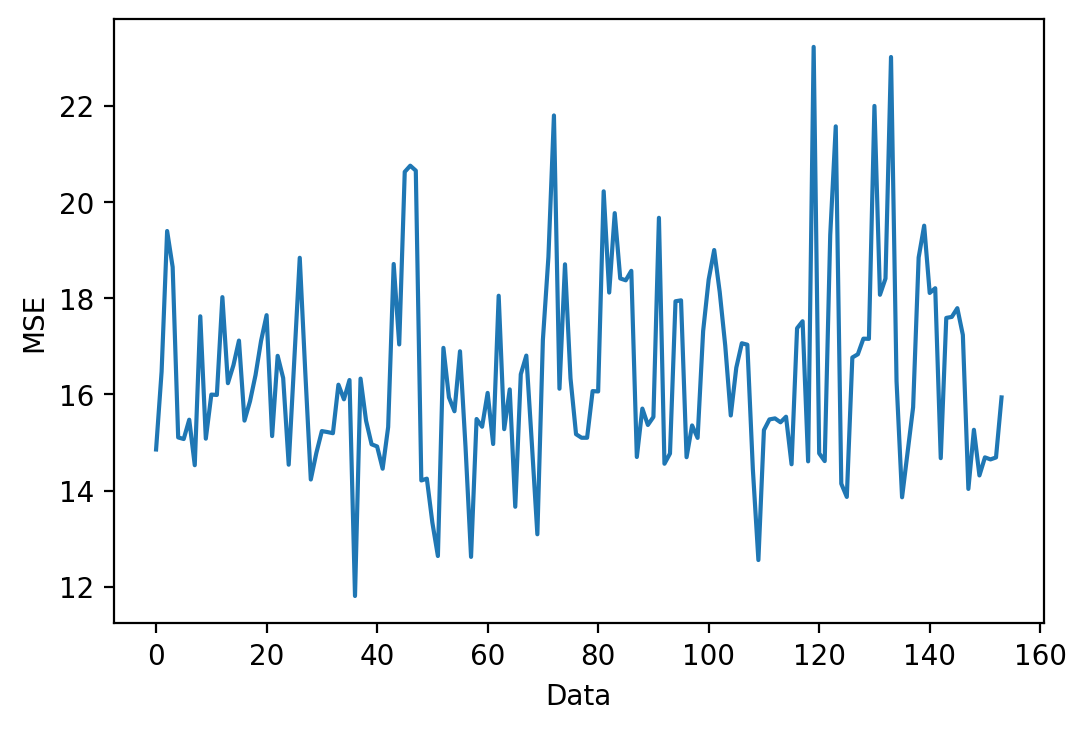

In [154]:
threshold_determine(vae, dataloader_proliv)

Основываясь на графиках и сдредних MSE стоит взять порог равный 12

In [155]:
# Сгенерированное изображение из распределения лунок без пролива
def showImgByCoord(autoencoder, x_1):
    interpolate_list = autoencoder.decoder(x_1)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()
    img  = interpolate_list.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

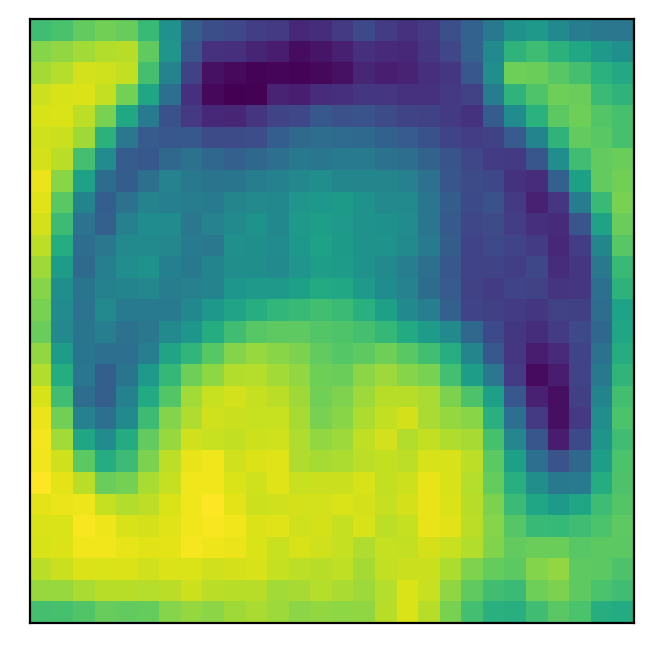

In [158]:
showImgByCoord(vae, torch.FloatTensor([[1,0]]).to(device))

# Определение проливов в лунках

In [43]:
import pandas as pd

In [44]:
data_dir_test = PATH + '/test/' 

In [52]:
# Загрузка кастомных датасетов
class LunkiDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, header = None, delimiter=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]).replace("\\","/")
        print(img_path)
        image = Image.open(img_path)
        print(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [53]:
dataset_Test = LunkiDataset(
    csv_file= data_dir_test +'test_annotation.txt',
    root_dir= data_dir_test +'imgs',
    transform=transform,
)
test_loader_data = DataLoader(dataset=dataset_Test)

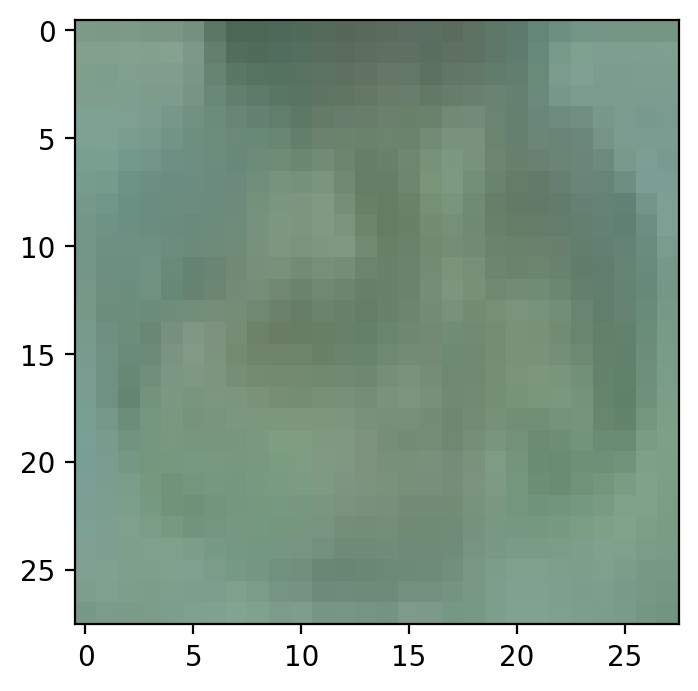

In [252]:
#plt.imshow(torch.einsum('cwh->whc', imagesTest[0]))

In [164]:
len(test_loader_data)

3794

In [47]:
### Функция классификации лунок
def classifiyLunki(autoencoder,dataset):
    y_true = list()
    y_pred = list()
    
    count = 0
    for x, y in test_loader_data:
        count+=1
        
        x = x.to(device) # GPU
        x_hat = autoencoder(x)

        #print(y.detach().numpy()[0])
        #print(((x - x_hat)**2).sum().to('cpu').detach().numpy())
        y_true.append(y.detach().numpy()[0])
        if ((x - x_hat)**2).sum().to('cpu').detach().numpy() <= 12:
            y_pred.append(0)
        else:
            y_pred.append(1)
        #print("x: ",x)
        #print("y: ",y)
        #x = x.to(device) # GPU
    return [y_true,y_pred]


In [286]:
# Создание листа с набором предсказанных и реальных меток
labels = classifiyLunki(vae,test_loader_data)

C:/Users/Andrej/1_GAN/dataset/test/imgs/b9bc8d6d-0cb6-40c2-a38d-61b4a3bef76e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9d3893a3-c877-4873-81c5-91aaaea018ea.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2C10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4f5cef60-bf06-4daf-be8d-a36b06a94a7d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x189BE4CA2E0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/37ee27b2-89a3-4b66-98a4-fb39b682a9c7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x23 at 0x189BE4D2C10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/43543d1a-24b6-4018-af56-27fe1c1824d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f1fab71-7f95-4079-8908-9d1b926c8c25.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2C10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f6c22716-3bde-48a7-ab8d-78e1e834c9c4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x32 at 0x189BE4D2C10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1ec3ca1a-7474-4dd0-bc30-69760cd0c8ec.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ffa889a1-78b9-4bb0-8c59-05debe641f3d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4CA7C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f6ea15e-9216-4b88-88e3-4673eb433157.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x189BE4CA7C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9ae95fbd-5192-4335-ba8e-d46c52f026a6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2C10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/50063e41-e6f9-4dc2-9557-2c58b30cc580.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c209d5e0-caf0-4732-b24b-9269f053b99e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a9ea79e1-8264-4392-bc68-1cf103a5799e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x32 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b8d756a7-3a4b-4a7d-b16f-87fe5ce71885.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/01ddb40a-f262-40ad-8bd7-24ca028e4618.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x32 at 0x189BE4CAA00>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e88eae6a-c82b-454d-920b-518adde29345.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a49997f1-29d3-44d4-85de-258f058d21e0.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1902dd42-d7fe-4fec-a48a-ec34c638532c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/14414ef8-cf10-4bfc-ac5c-b4a814015f5a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/17af4160-87cd-44c4-b895-f3df7e3db05a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a1301f25-d484-4751-ac4d-ed4166c69d3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b0e19bb3-1250-48b8-a2d4-4976a973bec9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/76e779ff-372f-4eb8-8d32-3e53769e5cea.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x23 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/df9de7c6-4386-4475-80b8-f06343cef411.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f8c6aab1-fef3-40b4-accb-7ec49763d2a0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bd04ea1f-5659-4e23-b408-54a2a4f01e51.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c32fd715-f365-4ac7-8bb4-c965dc96198b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=55x38 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ab2177a3-7352-4c4e-b390-925b44ff159d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7b90e434-ee1c-4202-b04a-d75ff9753ae6.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x189BE4CA7F0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3b35f1f3-0536-4295-b9cb-a74b76a963ef.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x25 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0b3267f6-cd50-4608-95a5-a4ef2a8adc42.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7e260ce1-50aa-4c11-9302-ddf8148cd4fc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7ceafbd4-3b58-4672-8b0f-c6e8a5929e04.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/86a6af83-2ec1-4eca-92e5-9065e64f87b1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f7cd4b96-fc8f-41d4-a270-f4ac96466480.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4CA7F0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/79258488-1c2e-4658-9307-a2387d1cebfe.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f837801a-e7ae-4a63-ac17-4a84a4d11266.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/24b1ff9a-d426-4835-aaa6-e8acc5c6847f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ae5d4fc7-51a3-4d33-82c7-4b6fe725fd18.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5842ea9d-309d-4868-84b4-ede6b37a3d21.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/35d3d61b-2b58-4598-94d4-7073f4c26705.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/30e1f83d-ceca-4bf6-b948-ab6bbc3e6ff9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5927b8bb-f707-40c2-bbd9-b6be5f21ef6d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/58060877-77cc-4385-bae8-f739ee73fb52.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d0ecc883-f8df-4712-9fb7-76955abb1e5e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/18a7ef50-5e0a-47e2-8b0f-f244fc07b8ab.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x28 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/011bb93b-406c-46f4-ba56-5d400c3f2f86.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4CAA60>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4bf01f2d-3b21-4dfb-b494-8f794d409562.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x35 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a79cc671-8d01-4778-a783-1a711a047505.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/097baaf7-1932-4fc3-b850-d8057041f296.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4CA820>
C:/Users/Andrej/1_GAN/dataset/test/imgs/485f5abe-6471-4fa0-9ec1-2fe63c244e69.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5b64c9fb-6fcb-46af-9b69-97f2c3bca82c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7ddd83a0-a0c4-470c-aa03-bdaf67476332.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x189BE4CA280>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f8d87b70-41ac-4ac7-8218-b23c5272e5ac.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/25764c33-0424-4b47-9444-d147030bc5cd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a62e2239-1ffc-4f0c-a529-f026d4d1af78.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5f8d949f-4b85-4fef-a4a2-42358e636153.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x27 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/32a5ecf8-203e-42d1-b945-4bb546120716.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a56c1c94-bd92-4d81-90dd-5e2c04f4b41b.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/be7fe517-b07e-4e43-a87d-54dddf9207d1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x33 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7bc864a-46a2-478d-8408-2f9114ae0d95.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ef8cba00-1709-45f1-8248-79f3aaec2be7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9cd8667f-ff97-434e-9187-c47c701d25dd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6b795783-f021-4b6e-8e6e-49f78b65b428.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6eb7849e-940c-43e9-b041-9e161ff20399.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x189BE4CAA00>
C:/Users/Andrej/1_GAN/dataset/test/imgs/87e9fea8-9cf4-46fe-916a-1e29505157cc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/62e47c18-b5ac-45e1-931f-dfd61c3c67d4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b88cef5f-e112-4be4-b4c4-ae83e2f6d8e2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d50691c7-8265-443c-aacd-b12c988e19bf.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/da4e93e5-b8e9-4eb2-8f62-defa60982193.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x33 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a26c6501-e9b1-478c-b5e1-855386db36f1.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4CA820>
C:/Users/Andrej/1_GAN/dataset/test/imgs/08646500-f60e-44ef-8f6d-321f83d487da.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fb294208-25f7-4d02-86bb-65ac98167bb4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8a1cc410-a009-4a54-971f-f77ac1b15c08.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cc350c02-04d7-4dff-86e1-40299fdb1306.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/30fb12f6-a61d-4f8b-a6ad-5461f4b19663.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/32fb81f1-1b99-4b83-a13e-02e0d1c99ab8.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4CA310>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1c950381-70fa-4776-a8ff-06aed4fc138c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b30a70bd-1535-40f9-8dd5-6b02eab41c39.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1159f90d-09f8-436f-911b-a78f35ffa524.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61e25f37-aef5-4d1d-82cf-6d1a8babf6c4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/56b03683-21e6-4d07-9676-d30e95a17798.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0817abf3-d94d-40cb-815d-a0f90497cae9.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c0d66165-3e28-4ae0-a9b9-a9fd11b9d396.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2fbc88e0-051e-47e6-8f29-b650c7da8beb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x32 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fb1e9f52-b224-4ae6-89b4-1e8f55c47e09.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e7ba61d6-666b-47b9-b48b-e8938760ded5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d35868f1-6325-4acd-9876-bbe5513c863a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bc1bd3b4-8a1b-452c-8406-328a9571f058.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/303fa15a-4670-4fc1-9a6b-57c07e92d30c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cf2f6a54-9793-43ac-8a82-ae2a7b849888.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/43380654-e40f-4fc5-aec9-22ab382510bf.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x189BE4CA820>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7a14e69-31df-4fa0-9430-68d3d187c7fc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x25 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c76bbce3-a0e9-4978-b4f5-e02a8ad46ffd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0c7705b8-5c19-4a3e-b615-c167543ceaad.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x25 at 0x189BE4CA490>
C:/Users/Andrej/1_GAN/dataset/test/imgs/266ea941-6d7b-4e9b-bd76-0613cf8b7828.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f69d0566-8dd3-44d2-8c41-f448d72d53ad.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b4c44e8f-3e48-43f5-88d6-e895ea800e0b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e62302d4-f34c-4080-9caf-bfaa87371827.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0b5b2301-e3df-4bac-9b2b-162f3bdacb9f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4CA490>
C:/Users/Andrej/1_GAN/dataset/test/imgs/20d0e15d-d7fa-4f82-b973-fb2b2c033de8.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4CA7C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b352245b-0a30-4478-ba46-05d8ca08585b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ae858b79-002a-4aa6-9ece-9861bc73dc00.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3751dd71-048f-46d9-9b59-adc7956a38b8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0077cf7b-69cc-4803-9645-23d6a75487fb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3ec60e82-41ee-4c55-99da-a34d3dd95d4e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b45e1e82-3ad3-4d56-9d88-ac1f0f1c1f38.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/52b5ad51-559c-49ac-95da-0408b1736cc5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f4b1103f-186d-48cb-9b27-04998f40ec2e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/64834950-7ea7-4559-bedb-39ef15b34dea.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d052be07-dfde-4001-8f27-3520c5d0b20c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4CAA60>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fa097224-aeb1-417f-93c4-6eca7b4324d4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ffeca3ee-d8ae-4d7e-802e-22a7008fee4f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/30c46832-a779-4f8a-8ada-ac57b351b186.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c109f426-2d94-41ec-9181-2abec9dcd088.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4CA7F0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4f7bb767-35cf-4961-831b-d7ce69af7139.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/131b7d92-e990-49d1-8d20-656963f82b85.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4d30af72-a3be-4ed3-adad-8621af560b35.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/de997c7d-4189-4611-bd74-4cf07bbc4c9f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4CA520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/66ff624f-c431-447e-85e1-20414ff790b7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f68950cc-013b-4abf-ab70-5343b2b90f70.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2d2e3e79-d8a2-4742-91c4-d5e38328894f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/54cf604f-c3cb-4d29-b25e-35f6a651ef36.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/99f6a975-443e-48b3-86b5-f8edcbbf4991.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x23 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d5f93df3-3ec7-4f5b-ad93-a73b73b569bd.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4CAEE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5ba4067f-eba5-4891-bc1a-e6ccf3f7b82c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d3f6dbbb-3540-45eb-89bf-4e262b6a2942.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f9cdd046-31ac-4253-b283-481697d6df42.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b88f498d-ca47-4554-bd3f-638a818e361c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4CA7C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7a77e8a8-24a6-44aa-b64e-c46c969f2b0e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bf305fd8-e50d-4c6f-a096-ae17de37ed07.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/9c16655f-5883-4765-b692-d1e90edf2176.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0d762f12-7e14-46f7-81f6-fab491866c51.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/52e3cda8-e0d9-4e62-8aa0-d6a61ed0a577.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/54215f40-f5d7-40c3-b33f-51719126305c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4CA8B0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/60819fd3-cdb0-49de-9854-8444d866425a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b1eb82d9-829e-431a-8c11-2e3707d428b9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4CAA60>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bef88ff0-d615-479a-9682-b4274934cfeb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7309640c-497d-45b8-8831-a5d7ea2cb0f6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x23 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/de780fb6-2ae7-43bb-8d8a-08b4b378134a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x189BE4CA490>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ec812f0d-fb25-4e4b-a42c-e65fac244731.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9b43dddc-2a50-45cf-9aec-dc0fd035b394.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7b7d4e8-6cbf-4968-8863-49bb57ead6f2.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/abdbed17-5e05-4ae3-9d03-fbeb618d4a27.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3eb45383-46b3-46ea-91c5-8e7fcf696f01.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4CAE80>
C:/Users/Andrej/1_GAN/dataset/test/imgs/60f55e6e-f20a-4576-bd86-1ec0611684fb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ef56d764-6a4c-435e-92e7-6051e49352ad.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/45b2a9e2-df55-4b15-a02e-74f94adef85e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7bed852-6263-4d90-a5dd-adfa04169cdc.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x27 at 0x189BE4CA490>
C:/Users/Andrej/1_GAN/dataset/test/imgs/773f4f85-d05d-4935-b82a-ffeccbacaf48.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a0e6ca7b-177b-4b14-a1e5-071d4d6c6b43.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f22961c-20d7-4c8c-b4db-86dfdfed8de1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/171cf217-2a79-4997-89d5-9e07e63a3b05.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/10e9144f-5e21-4bfb-829c-1536c3f70f64.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/12d41c26-0d8c-45a4-b99b-540ed1bff883.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x189BE4CA280>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e5b1a037-23b3-4f1e-a9ba-db0536fff97e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3edfdcef-7880-446d-a3da-66376000b862.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x189BE4CAEE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/81292fcd-14a6-412e-8535-e30a34238ef6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8312ca39-a52e-470b-a714-c5b408e61eff.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2328ff33-1d0c-4aa5-b8c0-66beb2fb06d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9b75fb16-9c31-4445-9e0f-e185a5d6dd5d.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4CA8B0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6024045e-9d0f-4d4b-b1d4-4c4b0868d793.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e153c709-68da-4adb-870a-58aa5621a1cd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x189BE4CA7F0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/560b93dc-e09e-49bb-ad88-11661579af20.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b4fa3c21-a44c-4bd7-a07a-d0d6f0148f22.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c4e3a5b6-56f7-45a3-b392-f5ad51e360e4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4CA7C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/77dcdf13-3850-431c-b7d6-284ecf5fcf76.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4CA280>
C:/Users/Andrej/1_GAN/dataset/test/imgs/846ae327-bfd8-4670-ab93-486b4edcc467.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9c49ec3e-6bbd-4952-94d5-e5903ce94b18.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a753c15a-0578-4ce3-bc53-d83a8ec9e703.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/81bac735-693c-426b-86ac-44b9407fdf7e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/acb4b3ca-6444-4e1a-9404-36545a8c39c9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/517634c3-672e-45fa-b9e4-d808ec3f2f7c.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/79c12ecd-0a2f-4b24-bb3b-8f94e4350faa.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/77919af7-a7ee-4179-8f02-ce696db7a36b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6a0f03d7-558c-48f3-966b-29bb8521cb4a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/919c35f4-fce5-468c-9472-8f05d61e96b9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/287a1565-ab1a-4820-8775-5ea54a95c33f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/abeccda3-a998-419f-8708-973f0e2aca2b.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4CAEE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/42388e95-9ba1-4bf0-8e3c-4fc5331871ba.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7cd92318-162f-4010-a5b4-c61ac25cebcb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/54ecf6fa-7ac4-475f-8d84-3d0aa26e960e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8b5d7fbc-f43d-40e7-9fc3-9146c73cff4a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a4e663d8-f30c-4ee0-94a0-1d939cf2ff08.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2e844036-459b-49fa-a0c2-927594c2269d.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4942094c-63c1-485b-aa30-f702709d8b00.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/286df821-c600-4a26-9289-0325bf1040b1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/97db5950-cc07-4c0f-905b-826eddda0ba5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c71c3c07-5043-4bb3-a524-67ab3a85b61f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/48e8812e-203f-4eb0-85f6-62afc278398d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d1b8adbf-45fb-44ba-8a10-0d50d3355cf9.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4CA310>
C:/Users/Andrej/1_GAN/dataset/test/imgs/16c179bb-b634-4b29-923b-8bb2f3f98ed5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/93beb5ee-7689-4dfc-8c01-e1274949ff50.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5009d116-c92b-4337-b3cc-e7edb2b19e53.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9333d86d-9f45-4d75-bcd1-800db3af4ee3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/616f2add-4996-4f10-bad7-e0d589c3b7c3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8193a888-f98d-4578-a72c-b0b3c5fceb9b.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4CA7F0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4192cfd6-6c53-46dd-b366-7bd2442edad5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6614a608-caad-4f46-80bf-3dfd59762802.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c61b411f-cce0-4e2c-8c86-802b55bd0912.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f1d1856e-19ba-45e1-b771-9670d2f48be5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d32afd10-9b71-4ffd-97bd-41a794ca8c44.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0e7b9fb3-a140-404f-b30b-959ac42321d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/132fcbbd-d222-41e2-b29b-5ebbd70dfa30.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x27 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cf1b79bb-5ccd-4c9c-9cde-eb1324843e64.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/80c6cc0f-8fb3-482a-975f-a98b4cb583c7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3abd713b-7f1f-4bed-889d-79b85dd6aa9c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9faf6e0f-9e0a-4d20-bca5-f309d27d0c01.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a9a193b9-b308-4908-99f0-8ef318a398e8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0b230a75-ad27-4b86-9b8d-c68cf3ed9fa3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x189BE4CAA60>
C:/Users/Andrej/1_GAN/dataset/test/imgs/347e9c77-185f-4ada-979a-df959c4c0fb3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4CAA60>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9a15bc2c-0d8b-44f6-892f-24307895210d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/959d5c9c-5162-41d9-92e9-adc40af4c535.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e2687830-e79e-4548-ad9a-4eec39220b83.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x25 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/64772657-bdda-400f-9017-54fb2dee4538.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3a488c89-f451-4710-aa21-fb1d16d7682b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fa2cb1e4-9130-4db5-ab42-d25b5f105ddb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3a441a21-9da5-4ef3-80f7-e69f54e802e3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7a33d8d1-ad24-49ab-a536-d7719ddee299.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1176c964-5563-4354-90bf-9e415e9a7177.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/02e1fa98-75b5-49bb-bace-9abd9789a2b1.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x189BE4CAF10>
C:/Users/Andrej/1_GAN/dataset/test/imgs/df9ca4eb-ef71-4aa6-a551-74866b7a2413.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/97f0bf3e-6ecf-4939-8fa6-9c17abb6561f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4CA310>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f09c9392-2f0b-48b3-a5c9-35cc016cad22.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4e88721c-be74-49f7-a88e-76a7b3b1efd8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/439660e6-4e5d-47da-808e-2a538abfa52f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d25218f7-6744-4eb0-8a0f-392aa1aa0441.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/04a4361e-fb8a-41b7-bfce-b869180a7641.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/56acb96f-98b7-4bfa-8983-0ab45cff0faa.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/59e9af38-9f23-46ee-904a-0905f71b4d3f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x189BE4CA8B0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0af8975b-21fc-41af-8230-6226a698391d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x189BE4D27C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3d4b8848-e7c0-447f-a865-fbcf86d101c4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x189BE4D2EE0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cf2acfa6-e044-42af-80a1-705345b25d5f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x189BE4D2730>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

# Результат

In [289]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(labels[0], labels[1]).ravel()

C:\Users\Andrej\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [291]:
#True Positive Rate, чувствительность
'''Чувствительность — это мера того,
насколько хорошо модель машинного обучения может обнаруживать положительные случаи.'''
TPR = tp/(tp+fn)

In [292]:
# True Negative Rate, специфичность
'''Специфичность измеряет долю истинных отрицательных результатов,
которые правильно идентифицируются моделью.'''
TNR = tn/(tn+fp) 

In [293]:
print("TPR: ",TPR)

TPR:  0.7751937984496124


In [294]:
print("TNR: ",TNR)

TNR:  0.8559345156889495


# Попытка улучшить результат

Добавление слоя в энкодер и декодер для более плавной транформации из 2352 -> 3 -> 2352 пространства

In [24]:

class DecoderV2(nn.Module):
    def __init__(self, latent_dims):
        super(DecoderV2, self).__init__()
        self.linear0 = nn.Linear(latent_dims, 512)
        self.linear1 = nn.Linear(512, 1024)
        self.linear2 = nn.Linear(1024, 2352)

    def forward(self, z):
        z = F.relu(self.linear0(z))
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 28, 28))

In [25]:

class VariationalEncoderV2(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoderV2, self).__init__()
        self.linear0 = nn.Linear(2352, 1024)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear0(x))
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [26]:
class VariationalAutoencoderV2(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoderV2, self).__init__()
        self.encoder = VariationalEncoderV2(latent_dims)
        self.decoder = DecoderV2(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [27]:
def trainV2(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    lossTrack = list()
    epochList = list()
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            #print("x:",x)
            #print("x_hat:",x_hat)
            loss = ((x - x_hat)**2).sum() + 0.02*autoencoder.encoder.kl
            #print("((x - x_hat)**2).sum(): ",((x - x_hat)**2).sum().to('cpu').detach().numpy())
            #print("kl: ",autoencoder.encoder.kl.to('cpu').detach().numpy())
            loss.backward()
            opt.step()
        lossTrack.append(((x - x_hat)**2).sum().to('cpu').detach().numpy())
        epochList.append(epoch)
    
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.plot(epochList, lossTrack)
    plt.show()
    
    return autoencoder

Вычисление порога

100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


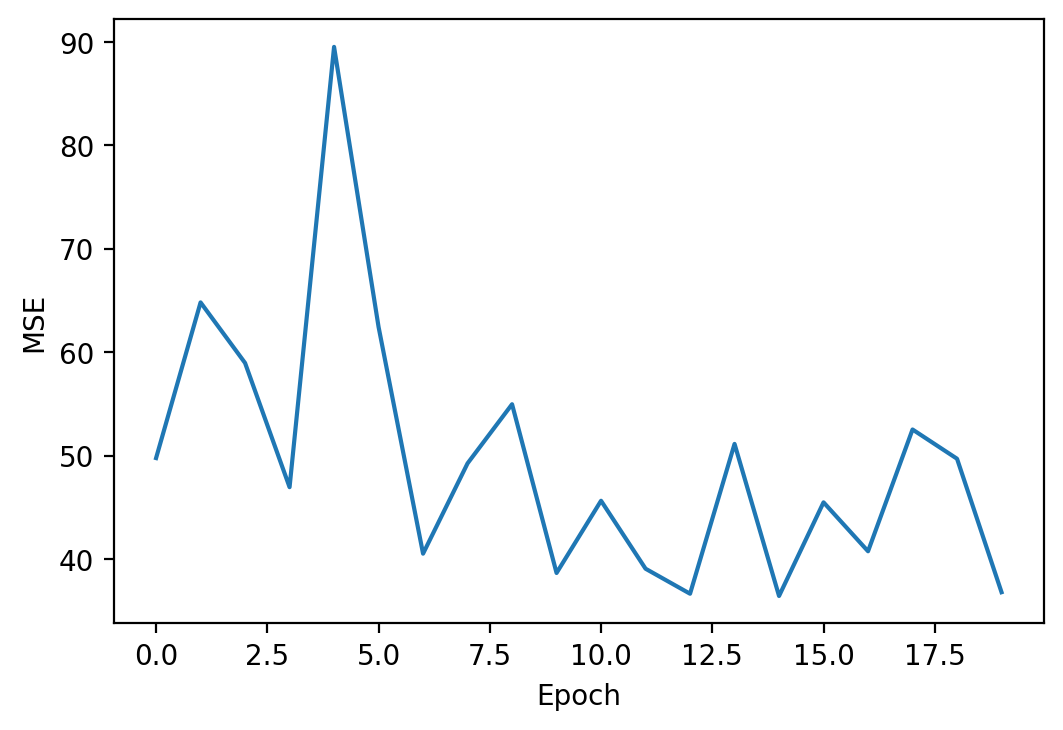

In [28]:
latent_dims = 3
vaeV2 = VariationalAutoencoderV2(latent_dims).to(device) # GPU
vaeV2 = trainV2(vaeV2, dataloader_train)

In [30]:
### Определения порога
def threshold_determine(autoencoder, data):
    lossTrack = list()
    
    count = 0
    for x, y in data:
        count+=1
        x = x.to(device) # GPU
        x_hat = autoencoder(x)

        lossTrack.append(((x - x_hat)**2).sum().to('cpu').detach().numpy())

    axesX = range(len(lossTrack))
    print("Count: ",count)
    print("Loss mean: ",sum(lossTrack)/len(lossTrack))
    plt.xlabel("Data")
    plt.ylabel("MSE")
    plt.plot(axesX, lossTrack)
    plt.show()

Загрузка данных без пролива

In [31]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor()
                               ])
dataset_train = datasets.ImageFolder(data_dir, transform=transform) 
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True) 

Count:  10000
Loss mean:  2.651626953125


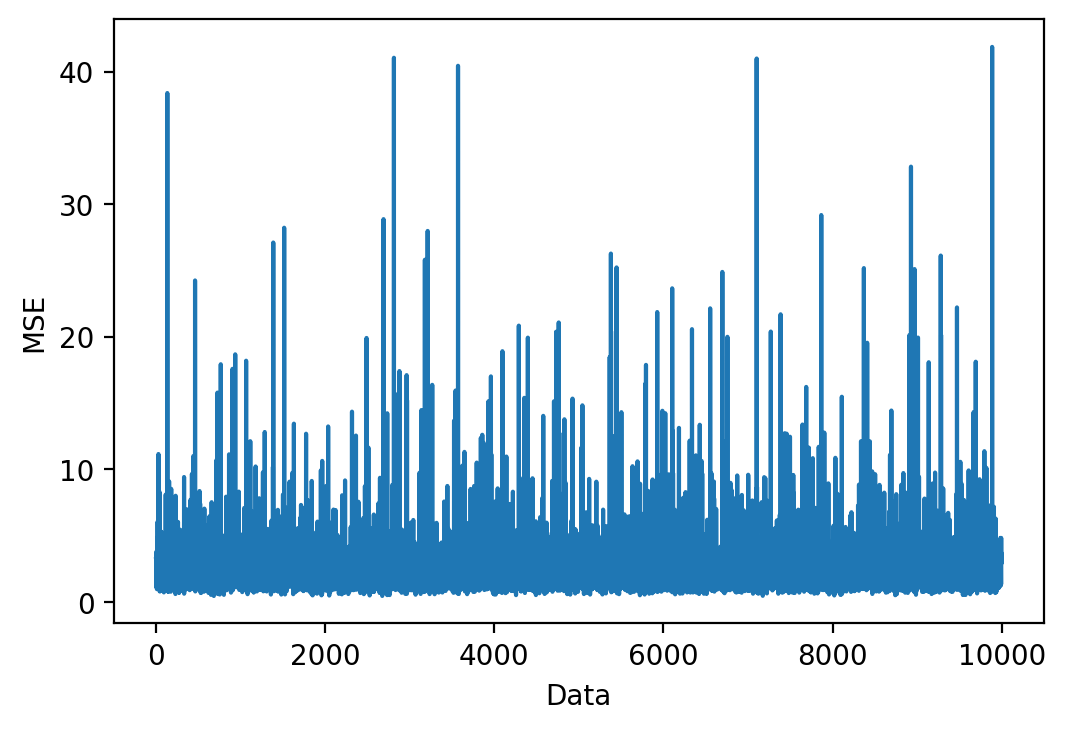

In [32]:
threshold_determine(vaeV2, dataloader_train)

Загрузка данных с проливом

In [40]:
data_dir_proliv = PATH + '/proliv' 

In [41]:
dataset_proliv = datasets.ImageFolder(data_dir_proliv, transform=transform) 
dataloader_proliv = torch.utils.data.DataLoader(dataset_proliv) 

Count:  154
Loss mean:  11.659618823559253


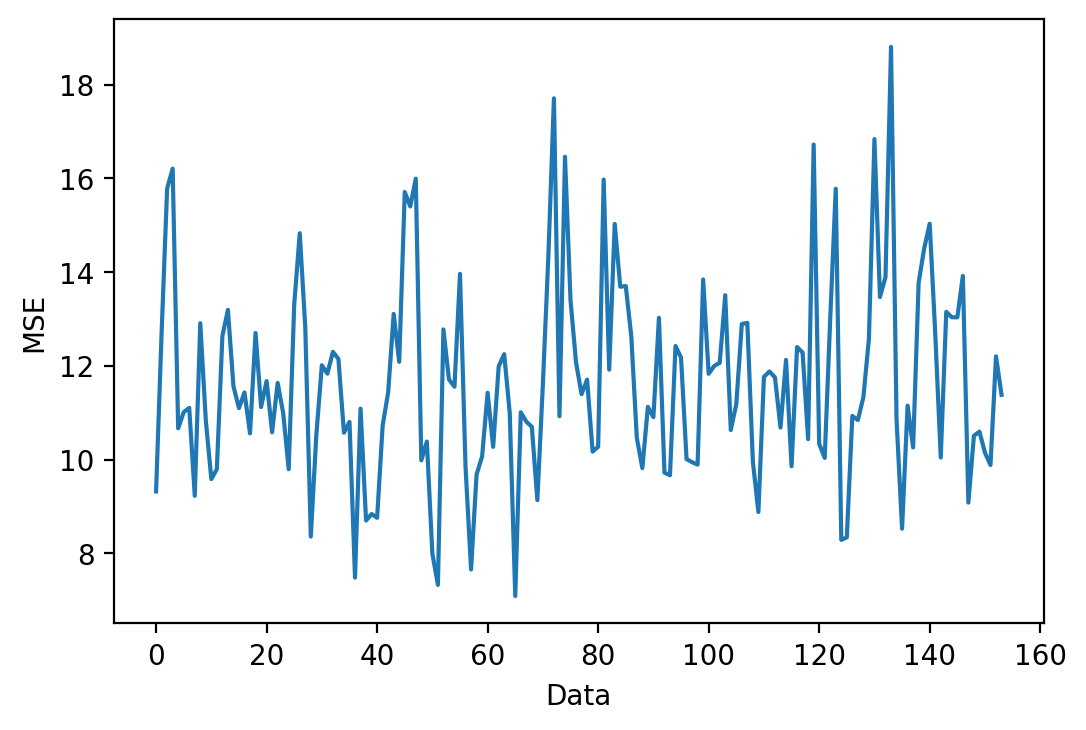

In [42]:
threshold_determine(vaeV2, dataloader_proliv)

Возьмём граничное значение равное 8

In [48]:
def classifiyLunkiV2(autoencoder,dataset):
    y_true = list()
    y_pred = list()
    
    count = 0
    for x, y in test_loader_data:
        count+=1
        
        x = x.to(device) # GPU
        x_hat = autoencoder(x)

        #print(y.detach().numpy()[0])
        #print(((x - x_hat)**2).sum().to('cpu').detach().numpy())
        y_true.append(y.detach().numpy()[0])
        if ((x - x_hat)**2).sum().to('cpu').detach().numpy() <= 8:
            y_pred.append(0)
        else:
            y_pred.append(1)
        #print("x: ",x)
        #print("y: ",y)
        #x = x.to(device) # GPU
    return [y_true,y_pred]

In [54]:
labels = classifiyLunkiV2(vaeV2,test_loader_data)

C:/Users/Andrej/1_GAN/dataset/test/imgs/b9bc8d6d-0cb6-40c2-a38d-61b4a3bef76e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9d3893a3-c877-4873-81c5-91aaaea018ea.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A9C811EB0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4f5cef60-bf06-4daf-be8d-a36b06a94a7d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x29A9C811940>
C:/Users/Andrej/1_GAN/dataset/test/imgs/37ee27b2-89a3-4b66-98a4-fb39b682a9c7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x23 at 0x29A9C811EB0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/43543d1a-24b6-4018-af56-27fe1c1824d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A9C811940>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f1fab71-7f95-4079-8908-9d1b926c8c25.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A9C811EB0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29A8F63D610>
C:/Users/Andrej/1_GAN/dataset/test/imgs/07beef28-7739-4e5a-9874-22b4fb021a8f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/84f1c3c9-1085-4642-bfdb-03e8272a9e42.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f4effe4-5e79-40a1-bea4-cf7ca56566ff.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63DCD0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bbf3590e-6cbe-4f6b-912a-2b10bffcdc86.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x23 at 0x29A8F63D610>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f58298b5-e4e8-4f31-9637-060635fba6b1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f1cf0b0f-aa29-4eab-9cd2-ec81bee91fd1.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/c74296e8-99ce-46e6-a745-7056dbcc441d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e0102682-c706-4899-830d-93c6f50938d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x25 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ba05f4a3-8a3f-4e5a-b344-1b229b47e4a4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DCD0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ffc874f8-2667-461b-ad4f-95672a1431b6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63D610>
C:/Users/Andrej/1_GAN/dataset/test/imgs/60edf48f-7850-4593-bec3-c9b3c2abf135.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0dc1a28e-5877-4acd-b48f-6e886ead6398.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/9f99198c-088d-4152-898e-860cad258eae.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/205b81ac-3000-43c8-82b4-3ab5f999a250.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7cbef28b-2788-411f-a91f-5a003341d98d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c65afc18-17bb-44a3-9fb9-93de86c5688b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/95edb57d-e2cd-403d-8c0b-4ad8cad5f0bc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/56c18e98-6ea4-4a8a-949f-2c85a338f66f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7dfc2e99-04d6-47d8-a693-43cb27d1e6e4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/271b7c64-7e2f-4072-90d6-d6223c884506.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/91085511-170e-4a98-869b-d381d3ebabd4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d0284e4b-b803-409f-8b40-9abf650fe16e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ef6a6790-2e19-4208-a60b-684618f170ae.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/16c84e96-13b2-4575-94f2-d69c14b51cae.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/909c81bc-13ec-4aa0-ae42-3cc68d0af8c2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e6c13b11-8839-4f59-bf96-a7cd5460abd1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/58ff77ff-4962-4551-9cd0-7ce1efbf37c7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5b2c36d8-f82b-4659-a1f5-1b035a71e059.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/640fe03d-6994-48f0-895f-3cfe89c72734.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ca543d1a-86a4-4d90-a961-ced0b2b37181.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/108b965d-e89d-481f-92b5-be647070739c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e8036b21-a682-4843-b573-815db1c4b099.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7bdf2d59-3f84-4e9c-9d18-e80e0252e262.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/875f9ee4-f92c-441d-99a7-7999feb69c1e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f5463892-61d2-416d-a7d7-70c9cd2bf926.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/79258488-1c2e-4658-9307-a2387d1cebfe.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/60c5315c-c128-41a9-b1e5-f3098d7bcd58.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b8b87902-e15b-469b-a17b-c4a6daf15a02.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/45840275-11aa-4581-897d-5350f9c87649.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ce276b04-9a3f-4015-8df6-132df71078cd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e8649b32-5db0-41d6-9efe-0a5afd4fc336.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/dce41700-08f9-406f-9d58-e0388b9dc8b7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61665ecf-5b63-46fa-a546-d6933bc62c3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f9e2dfda-0d48-4444-b377-f0d5210370f9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3f0b34ba-acfc-4060-9d0a-618f53a5a529.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0c1a007a-a0fe-436f-bf4b-5fdf15e717fc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6aac8a88-9655-4bc9-85aa-4579209f22ff.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/62b2944f-2d7b-4a07-9d92-cfe9cdc3577b.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/5a4240d7-1f42-44cc-ba0d-178876cd1e31.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5ae4ad4d-36bd-4c51-8604-637380637c87.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/beb37827-83a6-438c-9dc0-6f78d6ac897c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e7a32047-7e4f-4610-b667-0584d558f2c6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d337e07e-80cd-46e1-98a2-47fd1e3e7d92.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0b742f9d-99b0-4c2d-8993-92bd5f0cb045.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/02725c62-08c1-4349-9d17-0e5850f3661f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61887f57-731d-4bcd-a2e6-6b565da9efd7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/26927cb3-d942-446a-bd93-773dbbb95250.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/35cf30d3-03a4-4a68-a2cc-e7ea1a816e83.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/155f5f36-9583-499b-a984-3d73317f3594.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/82eb5465-6f84-4204-9d33-0e3ccd82e538.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/adb9ad99-ef57-4697-a208-f281d4ddc790.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9cbfa432-5759-4d00-9e70-331075226701.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d08b17e1-6780-4099-8b3f-30b375213aa1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/71d0fdec-2a5d-41fc-a420-1ae0d06b4b52.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/295c1dda-5d24-4d5a-9da0-3666cf557618.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0e96d3f7-5092-4c2f-b69e-6c2caa537325.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/99d9ef37-54dd-453d-b654-f470b37e25be.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/439c804c-8830-4366-afb3-433bdfa80887.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3545fe8f-98d1-41ee-8baf-a6847b22a868.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c574eaa7-d291-43ae-9f85-87ff34cc9093.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x34 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/454e98d5-b1d0-4f04-8033-3d0344d65178.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/efdae3d8-e5ec-4db1-8a2c-8ae50067fdd3.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/30dc5150-4151-488f-89d8-256245aa6219.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a11969ef-588b-441d-84d6-11d1e85d7774.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5ec2a8a0-a237-4f4b-b4a8-25abfa5243bc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5d33889d-416e-41c0-9d78-c39e63af7671.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8f42e765-2543-4100-a8ea-fcf5d385f306.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/21b2dff2-5bfb-46a2-b8cd-c4a779286fae.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/14e3b0a6-ebce-4623-abb0-2ba3555bdd44.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ec3bb309-c584-4769-a716-4bc26317b849.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0fd87761-8fea-4eac-b521-3e8ae817d775.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ed1dd0f3-14bf-422c-9a49-7a38d14afda8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x32 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/210295a9-9622-4723-a752-69fd5eb0e03c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/66d6ebed-870c-4fe9-baf1-fc3c6cfc3f7c.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7639f7d4-5e85-48f8-aa42-9b3954854e1f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ecb31854-ba09-4c80-a9fb-11c994d70c67.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b51494d0-5bd9-441a-9128-e8530cc75cb2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/468ffe2c-1a30-49c4-b467-5c1216628c18.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d50665a4-0207-4184-8373-120451cb996a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4a8479dd-fd5d-4f8a-b110-1d2e06fee4b8.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5bca1317-1cdd-43e9-9fc7-f873059b3fb4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1713dd4d-19b5-426d-ace5-93118e8b63db.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/95a73912-b093-41cc-a80c-c78c724c002b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c03b9c81-070e-4fbb-9c94-c3759d385dd0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a1bf8144-4ee2-40fe-ae54-50d914ff0c29.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3041e5fd-c150-46cb-a75f-576fc717c9bf.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=56x37 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/600f4bd1-95c0-461e-b8e1-fea33c3898ef.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2fe3809b-0907-4206-b170-36764776b8bd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8b884f29-61d8-43c3-bd50-9fad9ea28053.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ec426fcf-51c0-4403-b83b-9ebaf9833fd0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c746ea93-f434-4270-9c0d-71d055437d6c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8346c9de-500b-4af0-a181-ba3d024d5ec4.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=44x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5589926e-d3c9-46e4-ae8d-a35dff24648e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1cec2a8d-4170-4f44-891f-f06a0774b349.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/92dab94c-57a9-4ac0-a884-52dc26a66575.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/67cd2ad8-3a86-47e7-9084-dc0510e5e334.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0bfda6a1-9c92-4285-8b0a-8653c2fc0564.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8c7c1f34-1280-48a3-81db-20c50f18ee98.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/23b53197-2c57-4e69-ab2a-a0947467b45c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/629e3a73-3760-4f93-81b0-1212dc1a5528.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c0efddd0-224e-4313-a576-1680b14b33bb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/50c249c7-c906-4ce3-a1af-f403ba6f90f5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/66913229-aa3a-4db4-a828-67b03d9c481d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x25 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0d0c0e48-6afd-452e-814f-8280dc08d2b4.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f11d7fce-918a-4487-ae85-0147b083d98e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/348fd438-80b1-4ea1-8b15-c929c28725e7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fc1c63df-019f-4121-8b82-6e9c1fe55783.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8a35dc48-7159-46e4-8316-b04ebb856171.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f22c9e64-f610-4bb9-8de3-58d9b5d064e4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a6ce86b2-f43c-4053-afaa-81cb103a7955.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/47e3d6ff-b473-4400-8214-30e5e3fa9981.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=56x38 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/223dca3e-1a4e-4523-9222-6f1d4158516f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d9275ea5-c857-4faa-83cd-e5d07eea0c3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8112e205-5ab7-4447-863d-06b81c550f3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5255ede1-8aa0-4fa9-a3c4-5db7cc533093.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7c85cd19-2f0f-4596-a788-507afbc9dced.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/2f7742a7-990c-436c-92fb-e84faaf20563.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bc45838b-23b4-4b45-8689-4ea825abb786.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d546d29b-086d-4d56-b334-85101faf218f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/45df99ac-c7ba-4cf2-9a0a-b50133d9f7f1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5bda9f16-a080-4926-bca0-b9a72d0c1e19.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/41707deb-fd99-4db0-9926-7fb4c9a5ae8c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/d5a0eb78-b5b1-48ff-a4d0-53d6be4a53f6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/599161b5-54f6-4c11-8568-79b83d2e1f4d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/19c79478-a225-4637-a725-b27c1c47ed30.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61cc2848-323d-4e04-abc5-67b9c9b016e9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3597d81d-13a4-4ba0-8c42-a36d6949d1b6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c31dc776-4bf1-43d8-a4ed-d32209a60497.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/025ed760-5d12-417f-8daf-518698206373.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/04e826fe-11f0-4616-b4b2-d467f5f9cb1b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8f42a392-8cb3-4437-b3bd-216ffc5f38c3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/49ae8ca4-4214-492f-b2c6-69ea4b5b672a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e5e18f74-6d86-4ed8-b52b-b65c24ac62f0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/da3e7282-3502-40e2-8f77-a3529cf7bedb.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/884233c3-6455-47d8-bc91-909b0709e5c5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a364114d-3624-4544-8956-f2bfa001f6a6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/876e760d-3387-4f09-b374-9aa693d99eb4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/332d2dd5-01f4-4666-b626-d147c6554364.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/431ecd2b-9413-446b-ab3a-541baae35868.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/26b11718-8dcc-478d-a799-ef1f63c80f5d.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x25 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6f77a78d-78e0-415c-b532-c381665e37f0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/324e9a23-93cf-44ac-8fe7-22dfd06e43b0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d7d638cb-751c-4428-ae4a-7e68639a5384.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8cdf1af2-7591-4818-8879-28baef0969e5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x24 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/00f194d6-aee0-4132-9499-36429e34d501.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/863df04e-444d-444a-811f-7367992eb8ff.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/99f6a975-443e-48b3-86b5-f8edcbbf4991.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x23 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d5f93df3-3ec7-4f5b-ad93-a73b73b569bd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6371600e-208b-40eb-b86a-cd80a4217694.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3d8c1281-e94a-43ce-bd9d-4b8138c43cba.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/eb5ef520-0f2b-49fb-9acc-136970620a10.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2232b89c-627c-43e2-9fb5-f8c8cb75a961.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2f268ccb-2aff-4da9-bf1f-9b44ae9b4b53.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1897e526-bc7f-4183-97b4-8b94b1fe87c3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/51793436-592c-4006-abe5-29fa69d5d376.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/55fe7b56-75af-4dfd-a016-290efef99885.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x31 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61c1e9cb-705e-4b17-880b-24887e57202f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x29 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b4fcf549-8b32-4916-aed5-a18ececf3683.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/4cdc9eb2-04bd-4c53-9e4e-9d3549197ebf.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8f48a0fa-f644-47e7-b374-365f40641221.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1bdd9e3d-0479-4d3a-8fcf-4eb3b035c7d3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/249393f2-6ced-4e99-b381-382649720104.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ffdb2124-0984-4586-8ec3-6a8398130013.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7059ec59-07e0-4d0b-bfa8-63541aaec94b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/8bfe61ee-2bf0-4e09-8c7b-bc7c2d836c66.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6790a39b-50a5-4a7d-adbc-516a9514db85.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/50b39f77-ef70-4230-a494-2ee8f98a4ea7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8aa0a4fd-3a60-4d67-ab9c-634e5b3b8366.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ef46d5ec-bd52-4217-ac7a-25480e7c857b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/70c0da4b-ff43-406e-9ec2-ee169b90a063.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/5be5dc6c-9972-4c71-b072-da545bd6cc3b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e52807ac-0258-495e-b092-3e5b81ed5530.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3c5a7ff8-5bbc-4429-ae20-5a2d49d38421.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/582f8d1c-3ab0-4582-8963-8585a4af593a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b351d81b-185f-4218-8f7a-f50e5c59d4bf.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/97f7f471-dcaf-47f7-aa0d-5fd94317e007.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/42005d2e-e1cf-43f3-9318-90d05959b876.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/49592c54-0501-469e-8661-20e881a5a6f5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f126b054-bec4-4cb5-a7fd-c02a45607808.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/88360c9f-9ffc-44f8-a69f-88a53becee92.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/32b5e35a-d894-4063-9654-95b6bd5274fe.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/aae01b3f-04de-4157-87b2-2c940759c32d.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7c11563e-114d-4079-9372-d1e16476eee8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5a7978e4-cf2e-4323-ba20-936b81c99523.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/6adb0dec-a837-47e2-b5c9-4519178e72d2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/92fcdd57-7299-4018-b82e-41ef98e6e3dc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/596a5e6a-7660-4760-85cb-9ea1a83dbeaa.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9e034d6c-d5ff-4fa4-9bff-643cc30a1485.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ef56d764-6a4c-435e-92e7-6051e49352ad.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/45b2a9e2-df55-4b15-a02e-74f94adef85e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7bed852-6263-4d90-a5dd-adfa04169cdc.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e3ac367c-f720-415c-936a-b8cec8147fc9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1b397fdf-fc65-4f0d-a212-07a329b43750.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1a79fbee-aae4-40d0-903e-bcc814eca1ce.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/70aea80c-af2b-4849-abdf-189c025404ad.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/65416ac5-e26a-4aee-ac49-199d35418099.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3b44eef6-81bc-480f-9a52-8b3e89b931e1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/401706a0-a339-4398-bb1b-31738ecb1926.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/21883d1e-5869-4d7c-8728-4915f43a67df.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4bb4446b-4006-4b5f-b64b-3e020d4bb1b6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f22961c-20d7-4c8c-b4db-86dfdfed8de1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/171cf217-2a79-4997-89d5-9e07e63a3b05.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/10e9144f-5e21-4bfb-829c-1536c3f70f64.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/12d41c26-0d8c-45a4-b99b-540ed1bff883.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5e22bfc9-9dbe-4034-ad93-e3b3999e04ea.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7b6fa11e-2f78-4ff8-879b-59a7e38aae3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/1b49a168-a7ac-4fa5-8d73-a42b4afcc21a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x23 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/397f45f3-199f-44a1-882a-803717e0e42b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f2a75a73-fe85-4da9-9824-4151ba0983be.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3cce5313-86e8-4744-816b-f7b81ff8d908.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/05447fc5-3747-4bc0-9e74-78fd58cf0625.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x25 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d78eed9a-3230-4ba1-8efa-f1089179bb4c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/9976a670-23cb-4bd4-bbcf-e61d6771de97.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x27 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/975bf1d8-4ea6-4ef9-ad23-70c51a5b3d3a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/15e9fdb1-8bbd-4fc2-a18f-9f7d15c46fc3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/008bb51f-d93b-4ed2-9254-254de5c84694.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/647c82e4-63b8-4cd8-9664-c521021a3d10.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8bf993f1-40dc-492b-b44d-12f49427d9fe.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ca4dd353-b877-41aa-82f1-76cab6e684cd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x29 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a68bba28-5333-42f9-a800-9e6060e07538.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/eca00922-16f3-4b4f-bc2a-b7508652d166.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b19558b7-8a42-43b2-bb4e-b7a323b1a1c6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/82e5b10f-fd19-470f-8db6-31d00c6b23f6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f547e8ff-3bd9-4d0e-aa76-ef5059523083.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ab6e72b8-d5e5-48da-8113-0adbed9e5bac.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d3303476-2001-4de0-afbb-4c907b26cefa.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x34 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/62ed328f-c54d-44a0-9f83-6a5d196bef1f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d221ec75-5dd4-46d2-b299-4453fa0b43cb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/62e2e75e-652d-43f7-97e7-7165adf0c291.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2282ce39-e023-4302-a423-35ae74b7d0f3.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/c9867cb6-ca92-4f2c-a29b-40fea97fc827.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8b7ae2b8-6703-4fe6-adf3-60e805777f08.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d57bb10c-d7ab-4579-946a-c8da5c15dbe2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x25 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f625ed6a-f652-4f41-89bd-6e3a3c52378d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/62215043-d816-4246-a1a5-f159efd70e8c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9788b097-621c-4985-9bd0-037c2107a539.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29A8F63D580>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

C:/Users/Andrej/1_GAN/dataset/test/imgs/c2c74b5c-69b7-4412-9d6f-4cd587c3c8e7.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/93680fce-e60a-49c5-919f-4130cd657f55.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7b0159a0-32c8-4392-ba71-989199ddd238.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=54x33 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ced443bb-d0f9-4a79-b604-e4f3a49faa23.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cecc1188-a1a6-4e6b-b8b7-2480eed60b6a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7395b05b-d316-4e88-85e6-a5f3e19c4f16.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/54ecf6fa-7ac4-475f-8d84-3d0aa26e960e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8b5d7fbc-f43d-40e7-9fc3-9146c73cff4a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a4e663d8-f30c-4ee0-94a0-1d939cf2ff08.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2e844036-459b-49fa-a0c2-927594c2269d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5ddf1a04-d577-45df-a888-d348abb83d0b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/278a7c9c-4800-439b-ae37-5f372556a2b3.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c1909c02-869d-44a4-acbc-422e6a985968.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/205ad4c1-e099-4dae-9640-3c5142d478d0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x35 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4b260c40-3485-40b0-af50-0e0da993e4d0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/227135fd-3e96-49ed-a309-92383ae95793.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x24 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b2b88fc4-d18d-44e0-b43d-962d4b41f55d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB66A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4950bb14-156e-4f29-93fb-cf697cd0ec33.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/740876bd-f860-40ce-8573-5cf420dbf95e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ba0a02c6-5299-4179-b309-dbb2aebd4382.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/508000d7-1659-4183-b344-3183a742569c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f3472151-531e-4c7d-a07e-f39871dfe030.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/2727d365-eacf-4851-8978-7dc45405983d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8f6ee0aa-9989-44ce-8b43-b8f5455f5360.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63DDC0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x30 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/616f2add-4996-4f10-bad7-e0d589c3b7c3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8193a888-f98d-4578-a72c-b0b3c5fceb9b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29A8F63D6A0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/f4e7a76d-8567-428c-9be8-898569850cbe.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c00546fb-d151-4bc7-b592-da836f036480.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/095b465d-e7cc-425a-b5f0-b817811d7ff1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29A8F63D4C0>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b4006980-ebd6-48d2-afb9-bbc7b87c0346.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/890d987a-7ace-41df-a10a-a760aa63865c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4b904ec1-8bd4-4483-a071-fecbc1d0fed5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/91774de1-cfc2-4657-b026-b836a8fb1d59.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/24716006-754c-4ecf-9fbb-1fd1d6965bcb.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x32 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d5d3bbfd-e376-4ca2-9486-0be2aa71e090.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/80fa8293-7e65-44fe-85fc-7f27b21396bf.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=53x32 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/b7f25038-b797-4dad-bc34-b1026a6fea61.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/150d3ae3-ab76-4015-8e91-dc7b510646e8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d0c38a9d-6ac7-4045-a9ed-d47b094bbe46.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/793c7924-2fd6-40f4-a591-fbfb0a9aeaf6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/5557f596-b44a-4af1-950e-277232a87ed8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/cfbb7928-5467-4ad5-9063-48b53081a9f9.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c49a973e-36f3-48b7-b2a9-f94beb4afef1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c5605754-8464-4b60-9615-ff209af98012.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/eea8c81b-278d-43c7-9009-1d837b571121.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/bda399c0-7942-49bc-aaac-be1b1fa13282.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/df2ecc93-9275-4490-8566-68be9c9ebc72.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c64302c5-6f32-4550-9e89-59c1acdd64f3.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x24 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f3cb623-0180-4704-8e22-8b4b1449ace8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/dcc44f9e-9386-4717-8375-10cdcd3f56a2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/75938d1f-3743-4e62-b502-5cea4cf5f700.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x34 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/925763ac-f412-4a55-ae7c-2f312c706ba3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/7f78e20e-75f9-48c1-8620-227f3a11197d.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x28 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a72766f6-95ef-4065-b440-27707e94c8f4.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=45x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/23482836-4692-4f69-9604-f3458d182980.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/8cac29da-8f58-4f6b-9d43-cfe855bd9863.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/ba00f533-cc08-4ad3-af6b-6322029dd0d1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=57x37 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9ae03452-8c65-4a35-9ec2-ab2c033a4536.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x32 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/1f25d09a-26f3-41da-980c-3bcc5ef3a57b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0a062db2-1a0b-4a73-a4ad-f9180b9bf670.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/08388e9f-f5be-429d-af28-4eed36902dc8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3017bbdf-9f3a-4671-a807-84696addfafa.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=46x25 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/05e64e4d-e89e-40d0-830c-4659d2b25916.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/0eefea9a-47f1-4d3a-8e47-7b2685ab322f.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x26 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c5aec131-c686-4318-aa30-d7bd5dc54bbd.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x24 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4df07f5e-820d-4ad5-af6a-5a0b3e44506e.jpg
<PIL.JpegImagePlugin.JpegImageFile image

C:/Users/Andrej/1_GAN/dataset/test/imgs/0caf10da-47c8-4168-88cf-6e76d00a42e8.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x32 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/a9d625aa-66a9-4106-b387-4608f645c95c.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x29 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/51edf5bc-b163-4756-b1c0-90f65256033e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/9f5a3ced-5af8-4d0b-8ed7-2497006a15ed.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/3ededa07-11da-4c87-a966-8c194512ff52.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e46460ef-19c1-4ba0-bd1b-93b393d93f1e.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6550>
C:/Users/Andrej/1_GAN/dataset/test/imgs/

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/88ae3ca7-720f-4e20-b2e4-ebc39175acb3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x30 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/61b6dde1-8ddf-423c-8691-80144cbf24d6.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=50x28 at 0x29AFEBB6520>
C:/Users/Andrej/1_GAN/dataset/test/imgs/c77a184f-379f-472a-9357-ea0d1f5cc4f1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x23 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/e0af439f-532b-48a6-a2f7-31d474511288.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/32ef99a3-dbfd-4039-b875-1ab73bd23917.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x31 at 0x29AFEBB6670>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fcd8841e-4400-4f52-bb0f-a95915ff7d9b.jpg
<PIL.JpegImagePlugin.JpegImageFile image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=49x29 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fefb9211-127e-4832-b21b-36cbbe64aeb0.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/4c45c400-99a7-4b5e-afce-24ac08e3bda9.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x24 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/d4431494-e4ec-4e25-9364-f8cd6f607d96.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=51x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/27edbc23-d606-4dc6-8a6d-8a6cca0ce81b.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=54x30 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/520dc579-8df2-4146-beb2-adb15241cc4a.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=47x31 at 0x29AFEBB6190>
C:/Users/Andrej/1_GAN/dataset/test/imgs/fd1270e8-4a12-4e39-ad0d-a58f17b2a6c3.jpg
<PIL.JpegImagePlugin.JpegImageFile image

Результат

In [55]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(labels[0], labels[1]).ravel()

C:\Users\Andrej\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [57]:
#True Positive Rate, чувствительность
'''Чувствительность — это мера того,
насколько хорошо модель машинного обучения может обнаруживать положительные случаи.'''
TPR = tp/(tp+fn)

In [58]:
# True Negative Rate, специфичность
'''Специфичность измеряет долю истинных отрицательных результатов,
которые правильно идентифицируются моделью.'''
TNR = tn/(tn+fp) 

In [59]:
print("TPR: ",TPR)

TPR:  0.8992248062015504


In [60]:
print("TNR: ",TNR)

TNR:  0.8324693042291951


Вывод: с небольшим усложнением архитектуры неплохо вырос детект пролива, но и чаще стали помечаться нормальные лунки как с проливом.
В контексте задачи наверное лучше оставить последнию модель, те лучше с большей вероятностью детектить проливы и избежать испорченной продукции, чем отправить на дополнительную экспертизу форму без пролива.